## 1000-state Random Walk

- States are numbered form 1 to 1000, from left to right.
- All episode begin near the center on state 500.
- States 1 and 1000 are terminal states, and it fetches a reward of -1 and 1 on transitioning to them, respectively.
- Policy:
	* Agent can transition from current state to one of 100 states in left or rights, all with equal probability. So there are 200 possible actions. At edges, if an action goes beyond 1 or 1000, then the agent instead transition to the terminal states.
    
<img src="images/M6A1-P1.png" alt="M4A1-P3" width="500"/>

In [1]:
import numpy as np
from typing import Callable, List, Tuple, Sequence
from collections import defaultdict
import sys
import plots
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class random_walk_envioronment(object):
    def __init__(self, n_states : int = 1000):
        '''
        @params:
        n_states     :  Number of states in the example
        '''
        self.n_states = n_states # states numbered from 0 to (n_states - 1)
        self.cur_state = self.n_states//2
    
    def reset(self):
        self.cur_state = self.n_states//2
        return self.cur_state
    
    def step(self, action : int):
        '''
        @params:
        action      : Action as an integer. Basically a non-zero value denoting the number of steps taken in left or right direction.
        
        @doc:
        Takes an action in the MDP. And returns the next state, immediate reward, flag for episode termination
        and additional info (none here).
        '''
        next_state = None
        reward = 0
        done = False
        info = None
        
        next_state = self.cur_state + action
        
        if(next_state>= self.n_states):
            next_state = self.n_states - 1
        
        if(next_state < 0):
            next_state = 0
            
        if(next_state == self.n_states-1):
            reward = 1
            done = True
            
        if(next_state == 0):
            reward = -1
            done = True
        self.cur_state = next_state
            
        return next_state, reward, done, info

### Gradient Monte-Carlo

<img src="images/M6A1-P2.jpg" alt="M4A1-P3" width="500"/>

In [3]:
class gradient_monte_carlo_prediction(object):
    def __init__(self, env : random_walk_envioronment, n_buckets : int = 10, \
                 alpha : float = 2 * 1e-5, n_episodes : int = 100000, \
                 gamma : float= 1, n_left_jumps : int = 100, n_right_jumps : int =100) -> None:
        self.env = env
        self.alpha = alpha # Learning rate
        self.n_episodes = n_episodes  # Numbe of monte-calro episodes
        self.n_buckets = n_buckets # Number of buckets we want our state space to devided into
        self.gamma = gamma # Discount factor
        self.n_left_jumps = n_left_jumps # Number of steps possible in left
        self.n_right_jumps = n_right_jumps # Number of steps possible in right
        self.weights = np.zeros(self.n_buckets) # Number of weights in our linear function approximator is equal to number of buckets.
        self.possible_jumps = np.concatenate([np.linspace(-self.n_left_jumps,-1,self.n_left_jumps),\
                                              np.linspace(1,self.n_right_jumps,self.n_right_jumps)]) # All possible jumps. Negative number means jump in left direction and positive means jump in right direction
        assert self.env.n_states >=  self.n_buckets
    
    def get_state_representation(self, state : int) -> List:
        '''
        Given a state(value between 0 and self.n_states-1), it return the state representation (an array of size self.n_bucktes)
        '''
        bucket_size = np.ceil(self.env.n_states/self.n_buckets)
        state_rep = np.zeros(self.n_buckets)
        state_rep[int(state//bucket_size)] = 1
        return state_rep
        
    def value_function(self, state : int) -> float:
        '''
        Linear function approximator is used as the value function. 
        Given some state(0 to self.n_states-1), it return the value of that state.
        '''
        state_rep = self.get_state_representation(state)
        return np.dot(self.weights, state_rep)
    
    def policy(self, cur_state : int) -> int: 
        '''
        One of the possible (self.n_left_jumps + self.n_right_jumps) is selected as action.
        '''
        action = np.random.choice(self.possible_jumps)
        return action
    
    def generate_episode(self, max_episode_len : int = 1000000):
        '''
        Returns one episode as list of (state, action, reward) tuples 
        '''
        episode = []
        state = self.env.reset()
        for _ in range(max_episode_len):
            action = self.policy(state)
            new_state, reward, done, info = self.env.step(action)
            episode.append((state, action, reward))
            if done:
                return episode
            state = new_state
        return episode
    
    def estimate_state_value_function(self) -> None: 
        '''
        Updates weight to find the approximate value function for the given policy using Gradient Monte-Carlo 
        '''
        for episode_number in range(self.n_episodes):
            if((episode_number+1)%1000 == 0):
                print("\rEpisode {}/{}.".format(episode_number+1, self.n_episodes), end="")
                sys.stdout.flush()
            episode = self.generate_episode()
            G = 0
            for time_step in reversed(range(len(episode))):
                state, action, reward = episode[time_step]
                G = self.gamma * G + np.float(reward)
                target = G
                self.weights = self.weights + self.alpha * (target - self.value_function(state)) * self.get_state_representation(state)
        self.plot_value_function()
    
    def compute_true_values(self):
        '''
        Computes true value function, for comparison.
        '''
        states = np.arange(self.env.n_states)
        true_value = np.linspace(-1,1,self.env.n_states)
        true_value[0] = true_value[-1] = 0
        actions = self.possible_jumps
        for i in range(10000):
            max_diff = 0
            for state in states:
                if(state == 0 or state == self.env.n_states-1):
                    continue
                init_state_value = true_value[state]
                true_value[state] = 0
                for action in actions:
                    next_state = state + action
                    next_state = min(next_state, self.env.n_states-1)
                    next_state = max(next_state,0)
                    reward = 0 
                    if(next_state == self.env.n_states-1):
                        reward = 1
                    if(next_state == 0):
                        reward = -1
                    true_value[state] += ((1.0/(self.n_left_jumps + self.n_right_jumps)) * (reward + self.gamma * true_value[int(next_state)]))
                max_diff = max(max_diff,abs(init_state_value - true_value[state]))
            if(max_diff < 0.001):
                break
        return np.array(true_value)
        
    def plot_value_function(self):
        '''
        Plots the value function
        '''
        states = np.arange(self.env.n_states)[1:-1]
        values = [self.value_function(state) for state in states]
        true_values = self.compute_true_values()[1:-1]
        fig, ax = plt.subplots()
        plt.plot(states,values, label = 'Gradient Monte carlo')
        plt.plot(states,true_values, label = 'True value function')
        plt.ylabel('Value scale')
        plt.xlabel('State')
        plt.legend()
        plt.show()

Episode 100000/100000.

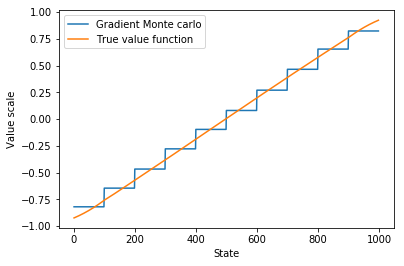

In [4]:
env = random_walk_envioronment()
gradient_monte_carlo_agent = gradient_monte_carlo_prediction(env, n_episodes=100000)
gradient_monte_carlo_agent.estimate_state_value_function()

### Semi-gradient TD(0)

<img src="images/M6A1-P3.jpg" alt="M4A1-P3" width="500"/>

In [5]:
class semi_gradient_td_prediction(object):
    def __init__(self, env : random_walk_envioronment, n_buckets : int = 10, \
                 alpha : float = 2 * 1e-5, n_episodes : int = 100000, \
                 gamma : float= 1, n_left_jumps : int = 100, n_right_jumps : int =100) -> None:
        self.env = env
        self.alpha = alpha # Learning rate
        self.n_episodes = n_episodes  # Number of episodes
        self.n_buckets = n_buckets # Number of buckets we want our state space to devided into
        self.gamma = gamma # Discount factor
        self.n_left_jumps = n_left_jumps # Number of steps possible in left
        self.n_right_jumps = n_right_jumps # Number of steps possible in right
        self.weights = np.zeros(self.n_buckets) # Number of weights in our linear function approximator is equal to number of buckets.
        self.possible_jumps = np.concatenate([np.linspace(-self.n_left_jumps,-1,self.n_left_jumps),\
                                              np.linspace(1,self.n_right_jumps,self.n_right_jumps)]) # All possible jumps. Negative number means jump in left direction and positive means jump in right direction.
        assert self.env.n_states >=  self.n_buckets
    
    def get_state_representation(self, state : int) -> List:
        '''
        Given a state(value between 0 and self.n_states-1), it return the state representation (an array of size self.n_bucktes)
        '''
        bucket_size = np.ceil(self.env.n_states/self.n_buckets)
        state_rep = np.zeros(self.n_buckets)
        state_rep[int(state//bucket_size)] = 1
        return state_rep
        
    def value_function(self, state : int) -> float:
        '''
        Linear function approximator is used as the value function. 
        Given some state(0 to self.n_states-1), it return the value of that state.
        '''
        state_rep = self.get_state_representation(state)
        return np.dot(self.weights, state_rep)
    
    def policy(self, cur_state : int) -> int:
        '''
        One of the possible (self.n_left_jumps + self.n_right_jumps) is selected as action.
        '''
        action = np.random.choice(self.possible_jumps)
        return action
    
    
    def estimate_state_value_function(self) -> None:  
        '''
        Updates weight to find the approximate value function for the given policy using semi-gradient TD(0). 
        '''
        for episode_number in range(self.n_episodes):
            if((episode_number+1)%1000 == 0):
                print("\rEpisode {}/{}.".format(episode_number+1, self.n_episodes), end="")
                sys.stdout.flush()
            
            state = self.env.reset()
            while(True):
                action = self.policy(state)
                next_state, reward, done, info = self.env.step(action)
                if(done):
                    target = reward
                else:
                    target = reward + self.gamma * self.value_function(next_state)
                self.weights = self.weights + self.alpha * (target - self.value_function(state)) * self.get_state_representation(state)
                if(done):
                    break
                state = next_state
        self.plot_value_function()
        
    def compute_true_values(self):
        '''
        Computes true value function, for comparison.
        '''
        states = np.arange(self.env.n_states)
        true_value = np.linspace(-1,1,self.env.n_states)
        true_value[0] = true_value[-1] = 0
        actions = self.possible_jumps
        for i in range(10000):
            max_diff = 0
            for state in states:
                if(state == 0 or state == self.env.n_states-1):
                    continue
                init_state_value = true_value[state]
                true_value[state] = 0
                for action in actions:
                    next_state = state + action
                    next_state = min(next_state, self.env.n_states-1)
                    next_state = max(next_state,0)
                    reward = 0 
                    if(next_state == self.env.n_states-1):
                        reward = 1
                    if(next_state == 0):
                        reward = -1
                    true_value[state] += ((1.0/(self.n_left_jumps + self.n_right_jumps)) * (reward + self.gamma * true_value[int(next_state)]))
                max_diff = max(max_diff,abs(init_state_value - true_value[state]))
            if(max_diff < 0.001):
                break
        return np.array(true_value)
        
    def plot_value_function(self):
        '''
        Plots the value function.
        '''
        states = np.arange(self.env.n_states)[1:-1]
        values = [self.value_function(state) for state in states]
        true_values = self.compute_true_values()[1:-1]
        fig, ax = plt.subplots()
        plt.plot(states,values, label = 'Semi-gradient TD')
        plt.plot(states,true_values, label = 'True value function')
        plt.ylabel('Value scale')
        plt.xlabel('State')
        plt.legend()
        plt.show()

Episode 100000/100000.

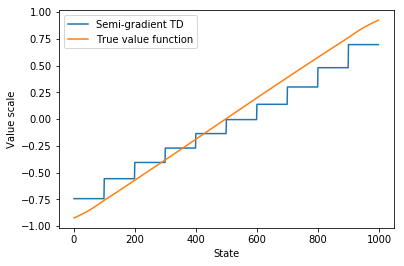

In [6]:
env = random_walk_envioronment()
semi_gradient_td_agent = semi_gradient_td_prediction(env, alpha=0.001)
semi_gradient_td_agent.estimate_state_value_function()

### Gradient Monte-Carlo with tile coding

In [7]:
class gradient_monte_carlo_prediction_with_tile_coding(object):
    def __init__(self, env : random_walk_envioronment, n_tilings : int = 50, \
                 n_tiles : int = 5, offset : int = 4, alpha : float = 2 * 1e-5, n_episodes : int = 100000, \
                 gamma : float= 1, n_left_jumps : int = 100, n_right_jumps : int =100) -> None:
        self.env = env
        self.alpha = alpha # Learning rate
        self.n_episodes = n_episodes # Number of episodes
        self.n_tilings = n_tilings # Numbe rof tiling for tile coding
        self.n_tiles = n_tiles # Number of tiles in each tiling.
        self.offset = offset # Tile offset for each tiling
        self.gamma = gamma # Discount factor
        self.n_left_jumps = n_left_jumps # Number of steps possible in left
        self.n_right_jumps = n_right_jumps # Number of steps possible in right
        self.weights = np.zeros((self.n_tiles+1) * self.n_tilings) # Number of weights is equal to number of elements in state represntation.
        self.possible_jumps = np.concatenate([np.linspace(-self.n_left_jumps,-1,self.n_left_jumps),\
                                              np.linspace(1,self.n_right_jumps,self.n_right_jumps)]) # All possible jumps. Negative number means jump in left direction and positive means jump in right direction
        self.state_representation = self.get_all_representation() # Store sttae represntation in a dictionary, for faster execution.
    
    def get_all_representation(self) -> dict:
        '''
        Returns state representation of each state, as a dictionary.
        Tile coding is used to get the sttae representation. 
        Number of tiles in each tiling will be one more than what is passed as parameter in the constructor. This is to account for the offset.
        Size of state reprsentation array of one state = (self.n_tiles + 1) * self.n_tilings
        '''
        state_representation = {}
        for state in range(self.env.n_states):
            state_rep  = np.array([])
            current_offset = 0
            for tiling in range(self.n_tilings):
                bucket_size = np.ceil(self.env.n_states/self.n_tiles)
                offset_state = state - current_offset
                if(offset_state<0):
                    index_on = 0
                else:
                    index_on = offset_state//bucket_size + 1
                tiling_state_rep = np.zeros(self.n_tiles + 1)
                tiling_state_rep[int(index_on)] = 1
                state_rep = np.hstack([state_rep,tiling_state_rep])
                current_offset = current_offset + self.offset
            state_representation[state] = state_rep
        return state_representation
        
    def value_function(self, state : int) -> float:
        '''
        Linear function approximator is used as the value function. 
        Given some state(0 to self.n_states-1), it return the value of that state.
        '''
        state_rep = self.state_representation[state]
        return np.dot(self.weights, state_rep)
    
    def policy(self, cur_state : int) -> int:
        '''
        Updates weight to find the approximate value function for the given policy using semi-gradient TD(0). 
        '''
        action = np.random.choice(self.possible_jumps)
        return action
    
    def generate_episode(self, max_episode_len : int = 1000000):
        '''
        Returns one episode as list of (state, action, reward) tuples 
        '''
        episode = []
        state = self.env.reset()
        for _ in range(max_episode_len):
            action = self.policy(state)
            new_state, reward, done, info = self.env.step(action)
            episode.append((state, action, reward))
            if done:
                return episode
            state = new_state
        return episode
    
    def estimate_state_value_function(self) -> None:  
        '''
        Updates weight to find the approximate value function for the given policy using gradient monte carlo with tile coding. 
        '''
        for episode_number in range(self.n_episodes):
            if((episode_number+1)%1000 == 0):
                print("\rEpisode {}/{}.".format(episode_number+1, self.n_episodes), end="")
                sys.stdout.flush()
            episode = self.generate_episode()
            G = 0
            for time_step in reversed(range(len(episode))):
                state, action, reward = episode[time_step]
                G = self.gamma * G + np.float(reward)
                self.weights = self.weights + self.alpha * (G - self.value_function(state)) * self.state_representation[state]
        self.plot_value_function()
    
    def compute_true_values(self):
        '''
        Computes true value function, for comparison.
        '''
        states = np.arange(self.env.n_states)
        true_value = np.linspace(-1,1,self.env.n_states)
        true_value[0] = true_value[-1] = 0
        actions = self.possible_jumps
        for i in range(10000):
            max_diff = 0
            for state in states:
                if(state == 0 or state == self.env.n_states-1):
                    continue
                init_state_value = true_value[state]
                true_value[state] = 0
                for action in actions:
                    next_state = state + action
                    next_state = min(next_state, self.env.n_states-1)
                    next_state = max(next_state,0)
                    reward = 0 
                    if(next_state == self.env.n_states-1):
                        reward = 1
                    if(next_state == 0):
                        reward = -1
                    true_value[state] += ((1.0/(self.n_left_jumps + self.n_right_jumps)) * (reward + self.gamma * true_value[int(next_state)]))
                max_diff = max(max_diff,abs(init_state_value - true_value[state]))
            if(max_diff < 0.001):
                break
        return np.array(true_value)
        
    def plot_value_function(self):
        '''
        Plots the value function.
        '''
        states = np.arange(self.env.n_states)[1:-1]
        values = [self.value_function(state) for state in states]
        true_values = self.compute_true_values()[1:-1]
        fig, ax = plt.subplots()
        plt.plot(states,values, label = 'Gradient MC with tile coding')
        plt.plot(states,true_values, label = 'True value function')
        plt.ylabel('Value scale')
        plt.xlabel('State')
        plt.legend()
        plt.show()

Episode 100000/100000.

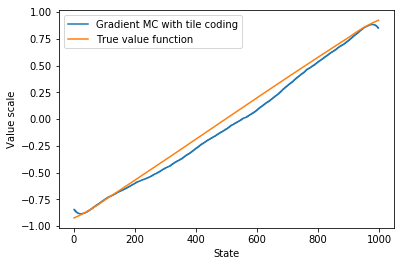

In [8]:
env = random_walk_envioronment()
gradient_mc_prediction_tile_coding_agent = gradient_monte_carlo_prediction_with_tile_coding(env, alpha=0.0002/50)
gradient_mc_prediction_tile_coding_agent.estimate_state_value_function()